In [42]:
from sympy import *
import numpy as np
import pandas as pd
from copy import copy,deepcopy
import random
import matplotlib.pyplot as plt
import sys

In [43]:
def plotCA(data,size=(20,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(data,plt.cm.Greys)
    plt.ylabel("steps",fontsize="large")
    for i in range(len(data)):
        for j in range(len(data[i])):
            c = "w"
            if data[i][j] <= 2:
                c = "black"
            text = ax.text(j, i, data[i][j],
                           ha="center", va="center", color=c,fontsize="large")
    plt.show()

def cpAp(e,lst):
    a = np.append(e,lst)
    return a

def aptitud(pos,neg,notapt):
    pos_values = {}
    neg_values = {}
    onlykeys = {x[0] for x in notapt}
    for i in range(len(pos)):
        for j in range(len(pos[i])):
            if str(j) not in pos_values:
                pos_values[str(j)+",1"] = 0
                pos_values[str(j)+",0"] = 0
            if pos[i][j] == 1:
                key = str(j)+",1"
            else:
                key = "{},0".format(j)
            if key not in onlykeys:
                pos_values[key] += 1
    for i in range(len(neg)):
        for j in range(len(neg[i])):
            if str(j) not in neg_values:
                neg_values[str(j)+",1"] = 0
                neg_values[str(j)+",0"] = 0
            if neg[i][j] == 1:
                key = str(j)+",1"
            else:
                key = "{},0".format(j)
            if key not in onlykeys:
                neg_values[key] += 1
    res = []
    for key in pos_values:
        if neg_values[key] == 0 and pos_values[key] != 0:
            res.append([key,1000])
        elif neg_values[key] != 0:
            res.append([key,pos_values[key]/neg_values[key]])
    res.sort(key=lambda x: x[1],reverse=True)
    return res

def removeBest(pos,key):
    filtered = []
    key = key.split(",")
    index = int(key[0])
    value = int(key[1])
    for i in range(len(pos)):
        if pos[i][index] != value:
            filtered.append(pos[i])
    return filtered

def removeNeg(neg,t):
    newneg = []
    for i in range(len(neg)):
        add = False
        for j in range(len(t)):
            key = t[j]
            key = key.split(",")
            index = int(key[0])
            value = int(key[1])
            if neg[i][index] == value:
                add = True
                break
        if add:
            newneg.append(neg[i])
    return newneg

def ocat(data,m):
    neg = deepcopy(data["neg"])
    C = []
    while len(neg) > 0:
        t = []
        pos = deepcopy(data["pos"])
        notapt = []
        while len(pos) > 0:
            apt = aptitud(pos,neg,notapt)
            if m >= len(apt):
                notapt = []
            else:
                notapt = apt[m:]
                apt = apt[:m]
            best = apt[0]
            t.append(best[0])
            pos = removeBest(pos,best[0])
        C.append(t)
        neg = removeNeg(neg,t)
    return C

In [44]:
def testRulesOneDimension(initConfig,iterations,rules):
    appliedRules = {}
    evolution = [] 
    curr = copy(initConfig)
    evolution.append(curr)
    for step in range(iterations):
        if step not in appliedRules:
            appliedRules[step] = {}
        newCurr = copy(curr)
        for i,cell in enumerate(curr):
            if i not in appliedRules[step]:
                appliedRules[step][i] = []
            for j,op in enumerate(rules):
                A0 = 0
                A1 = cell
                A2 = 0
                if i != 0:
                    A0 = curr[i-1]
                if i != len(curr)-1:
                    A2 = curr[i+1]
                if eval(rules[op]):
                    newCurr[i] = op
                    appliedRules[step][i].append(op)
        curr = newCurr
        evolution.append(curr)
    return {"history":evolution,"appliedRules":appliedRules}                      

<img src="images/squaringCA.png"/>

Para cada uno de los atributos encontrar su funcion de trancision local
## cargamos el dataset del automata celular que calcula 2^2

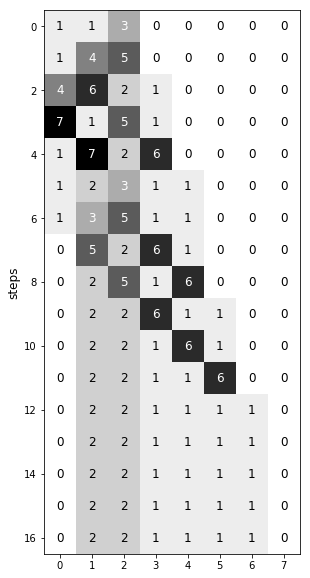

In [45]:
dataframe = pd.read_csv("data/2_square.csv")
plotCA(dataframe.values)

### Eliminamos las filas redundantes

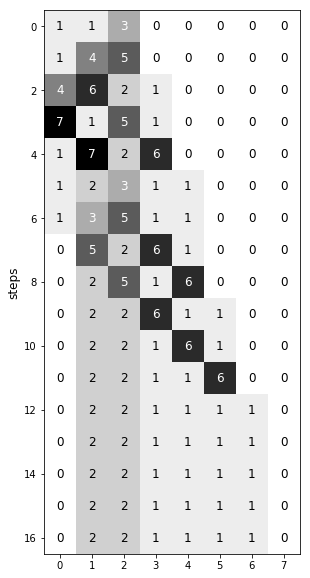

In [46]:
#dataframe = dataframe.iloc[np.tile([True,False], 7),:]
plotCA(dataframe.values,(15,10))

In [47]:
#creamos un problema de aprendizaje para cada celda
attr_state = {}
for i,row in dataframe.iterrows():
    for j in range(len(dataframe.columns)):
        if j not in attr_state:
            attr_state[j] = []
        x1 = 0
        x2 = row[j]
        x3 = 0
        if j != 0:
            x1 = row[j-1]
        if j != len(dataframe.columns)-1:
            x3 = row[j+1]
        attr_state[j].append([x1,x2,x3])
attr_state[0] 

[[0, 1, 1],
 [0, 1, 4],
 [0, 4, 6],
 [0, 7, 1],
 [0, 1, 7],
 [0, 1, 2],
 [0, 1, 3],
 [0, 0, 5],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2],
 [0, 0, 2]]

In [48]:
problem = {}
for col in attr_state:
    for row in range(1,len(attr_state[col])):
        icenter = floor(len(attr_state[col][row])/2)
        if attr_state[col][row][icenter] not in problem:
            problem[attr_state[col][row][icenter]] = {}
        k = ",".join(map(str,attr_state[col][row-1]))
        if k not in problem[attr_state[col][row][icenter]]:
            problem[attr_state[col][row][icenter]][k] = attr_state[col][row-1]
problem

{1: {'0,1,1': [0, 1, 1],
  '0,7,1': [0, 7, 1],
  '0,1,7': [0, 1, 7],
  '0,1,2': [0, 1, 2],
  '4,6,2': [4, 6, 2],
  '5,0,0': [5, 0, 0],
  '2,1,0': [2, 1, 0],
  '2,6,0': [2, 6, 0],
  '3,1,1': [3, 1, 1],
  '2,6,1': [2, 6, 1],
  '2,1,6': [2, 1, 6],
  '2,1,1': [2, 1, 1],
  '6,0,0': [6, 0, 0],
  '1,1,0': [1, 1, 0],
  '1,6,0': [1, 6, 0],
  '1,6,1': [1, 6, 1],
  '1,1,6': [1, 1, 6],
  '1,1,1': [1, 1, 1]},
 4: {'0,1,4': [0, 1, 4], '1,1,3': [1, 1, 3]},
 7: {'0,4,6': [0, 4, 6], '7,1,5': [7, 1, 5]},
 0: {'0,1,3': [0, 1, 3],
  '0,0,5': [0, 0, 5],
  '0,0,2': [0, 0, 2],
  '3,0,0': [3, 0, 0],
  '0,0,0': [0, 0, 0],
  '1,0,0': [1, 0, 0]},
 6: {'1,4,5': [1, 4, 5],
  '5,1,0': [5, 1, 0],
  '5,1,1': [5, 1, 1],
  '5,1,6': [5, 1, 6],
  '6,1,0': [6, 1, 0],
  '6,1,1': [6, 1, 1]},
 2: {'1,7,2': [1, 7, 2],
  '0,5,2': [0, 5, 2],
  '0,2,5': [0, 2, 5],
  '0,2,2': [0, 2, 2],
  '4,5,0': [4, 5, 0],
  '1,5,1': [1, 5, 1],
  '3,5,1': [3, 5, 1],
  '2,5,1': [2, 5, 1],
  '2,2,6': [2, 2, 6],
  '2,2,1': [2, 2, 1]},
 3: {'1,2,3'

In [49]:
matrix = []
for key in problem:
    for key2 in problem[key]:
        temp = copy(problem[key][key2])
        temp.append(key)
        matrix.append(temp)
matrix

[[0, 1, 1, 1],
 [0, 7, 1, 1],
 [0, 1, 7, 1],
 [0, 1, 2, 1],
 [4, 6, 2, 1],
 [5, 0, 0, 1],
 [2, 1, 0, 1],
 [2, 6, 0, 1],
 [3, 1, 1, 1],
 [2, 6, 1, 1],
 [2, 1, 6, 1],
 [2, 1, 1, 1],
 [6, 0, 0, 1],
 [1, 1, 0, 1],
 [1, 6, 0, 1],
 [1, 6, 1, 1],
 [1, 1, 6, 1],
 [1, 1, 1, 1],
 [0, 1, 4, 4],
 [1, 1, 3, 4],
 [0, 4, 6, 7],
 [7, 1, 5, 7],
 [0, 1, 3, 0],
 [0, 0, 5, 0],
 [0, 0, 2, 0],
 [3, 0, 0, 0],
 [0, 0, 0, 0],
 [1, 0, 0, 0],
 [1, 4, 5, 6],
 [5, 1, 0, 6],
 [5, 1, 1, 6],
 [5, 1, 6, 6],
 [6, 1, 0, 6],
 [6, 1, 1, 6],
 [1, 7, 2, 2],
 [0, 5, 2, 2],
 [0, 2, 5, 2],
 [0, 2, 2, 2],
 [4, 5, 0, 2],
 [1, 5, 1, 2],
 [3, 5, 1, 2],
 [2, 5, 1, 2],
 [2, 2, 6, 2],
 [2, 2, 1, 2],
 [1, 2, 3, 3],
 [7, 2, 6, 3],
 [1, 3, 5, 5],
 [1, 3, 0, 5],
 [6, 2, 1, 5],
 [2, 3, 1, 5],
 [5, 2, 6, 5]]

In [50]:
#encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
domain = {}
for row in matrix:
    for j,col in enumerate(row):
        if j not in domain:
            domain[j] = []
        if col not in domain[j]:
            domain[j].append(col)
for key in domain:
    domain[key].sort()
domain

{0: [0, 1, 2, 3, 4, 5, 6, 7],
 1: [0, 1, 2, 3, 4, 5, 6, 7],
 2: [0, 1, 2, 3, 4, 5, 6, 7],
 3: [0, 1, 2, 3, 4, 5, 6, 7]}

In [51]:
#binarizamos los subproblemas de aprendizaje
binarizedMatrix = []
for row in matrix:
    rtemp = []
    for j,col in enumerate(row):
        if j < len(row)-1:
            for val in domain[j]:
                if col >= val:
                    rtemp.append(1)
                else:
                    rtemp.append(0)
        else:
            rtemp.append(col)
    binarizedMatrix.append(rtemp)
binarizedMatrix

[[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [52]:
# obtenemos los ejemplos positivos y negativos para el atributo x[1] de los subproblemas
keys = list(domain.keys())
pos_neg = {}
for row in binarizedMatrix:
    for val in domain[keys[-1]]:
        if val not in pos_neg:
            pos_neg[val] = {"pos":[],"neg":[]}
        if val == row[-1]:
            pos_neg[val]["pos"].append(row[:-1])
        else:
            pos_neg[val]["neg"].append(row[:-1])
pos_neg

{0: {'pos': [[1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0],
   [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
   [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],
  'neg': [[1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0],
   [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
   [1, 1, 1, 1, 1, 0, 0, 0, 

In [53]:
rules = {}
for key in pos_neg:
    if key not in rules:
        rules[key] = {}
    if len(pos_neg[key]["pos"]) > 0 and len(pos_neg[key]["neg"]) > 0:
        rules[key] = ocat(pos_neg[key],10)
rules

{0: [['2,0', '4,0'],
  ['2,0', '3,1'],
  ['9,0', '1,0'],
  ['1,1', '9,0', '10,0'],
  ['1,1', '9,0', '20,0'],
  ['1,1', '9,0', '19,1']],
 1: [['2,0', '6,1', '3,0', '4,0', '9,0', '5,0'],
  ['2,0', '3,1', '10,0', '12,1'],
  ['2,0', '9,0', '3,0', '4,0', '5,0'],
  ['10,0', '12,1'],
  ['2,0', '3,1', '10,0', '14,1'],
  ['2,0', '4,1', '3,0', '10,0'],
  ['10,0', '14,1'],
  ['10,0', '15,0', '1,0'],
  ['9,1', '2,1'],
  ['2,0', '4,1', '3,0', '9,1'],
  ['1,1', '19,0', '20,1'],
  ['18,0', '20,1', '2,1', '1,0'],
  ['1,1', '19,0', '21,1']],
 2: [['3,0', '4,0', '5,0'],
  ['11,0', '12,1'],
  ['2,1', '11,1', '1,0'],
  ['2,1', '13,1', '1,0'],
  ['1,1', '9,1'],
  ['3,0', '9,1'],
  ['1,1', '10,1'],
  ['1,1', '11,0', '13,1'],
  ['2,1', '14,0', '15,1'],
  ['10,1'],
  ['11,0', '14,0', '2,0'],
  ['1,1', '11,0', '14,0']],
 3: [['6,1', '2,0'],
  ['7,1', '2,0'],
  ['2,1', '11,0'],
  ['1,1'],
  ['2,1', '9,1'],
  ['10,1']],
 4: [['2,0'],
  ['10,0'],
  ['9,1'],
  ['1,1', '20,1'],
  ['18,1'],
  ['20,0', '1,0'],
  ['1,

In [54]:
keys = list(domain.keys())
oRules = {}
for cls in rules:
    if cls not in oRules:
        oRules[cls] = {}
    prop = []
    for clause in rules[cls]:
        expr = []
        for term in clause:
            col = 0
            ind = int(term.split(",")[0])
            val = int(term.split(",")[1])
            for key in keys:
                if ind >= (key * len(domain[key])) and ind <= ((key+1) * len(domain[key])):
                    col = key
                    ind -= (key * len(domain[key]))
                    break
            relational = (">=" if val== 1 else "<")
            t = "A{} {} {}".format(col,relational,domain[col][ind])
            expr.append(t)
        prop.append("({})".format(" or ".join(expr)))
    oRules[cls] = " and ".join(prop)
oRules

{0: '(A0 < 2 or A0 < 4) and (A0 < 2 or A0 >= 3) and (A1 < 1 or A0 < 1) and (A0 >= 1 or A1 < 1 or A1 < 2) and (A0 >= 1 or A1 < 1 or A2 < 4) and (A0 >= 1 or A1 < 1 or A2 >= 3)',
 1: '(A0 < 2 or A0 >= 6 or A0 < 3 or A0 < 4 or A1 < 1 or A0 < 5) and (A0 < 2 or A0 >= 3 or A1 < 2 or A1 >= 4) and (A0 < 2 or A1 < 1 or A0 < 3 or A0 < 4 or A0 < 5) and (A1 < 2 or A1 >= 4) and (A0 < 2 or A0 >= 3 or A1 < 2 or A1 >= 6) and (A0 < 2 or A0 >= 4 or A0 < 3 or A1 < 2) and (A1 < 2 or A1 >= 6) and (A1 < 2 or A1 < 7 or A0 < 1) and (A1 >= 1 or A0 >= 2) and (A0 < 2 or A0 >= 4 or A0 < 3 or A1 >= 1) and (A0 >= 1 or A2 < 3 or A2 >= 4) and (A2 < 2 or A2 >= 4 or A0 >= 2 or A0 < 1) and (A0 >= 1 or A2 < 3 or A2 >= 5)',
 2: '(A0 < 3 or A0 < 4 or A0 < 5) and (A1 < 3 or A1 >= 4) and (A0 >= 2 or A1 >= 3 or A0 < 1) and (A0 >= 2 or A1 >= 5 or A0 < 1) and (A0 >= 1 or A1 >= 1) and (A0 < 3 or A1 >= 1) and (A0 >= 1 or A1 >= 2) and (A0 >= 1 or A1 < 3 or A1 >= 5) and (A0 >= 2 or A1 < 6 or A1 >= 7) and (A1 >= 2) and (A1 < 3 or A1 

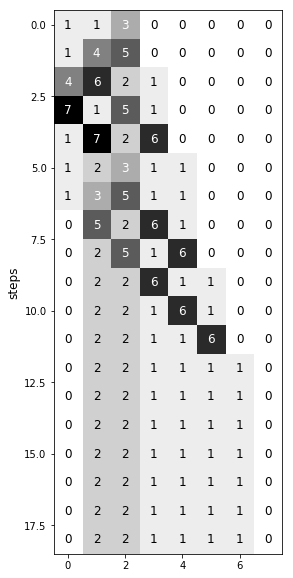

In [55]:
res = testRulesOneDimension([1,1,3,0,0,0,0,0],18,oRules)
plotCA(res["history"])

In [56]:
res["history"]

[[1, 1, 3, 0, 0, 0, 0, 0],
 [1, 4, 5, 0, 0, 0, 0, 0],
 [4, 6, 2, 1, 0, 0, 0, 0],
 [7, 1, 5, 1, 0, 0, 0, 0],
 [1, 7, 2, 6, 0, 0, 0, 0],
 [1, 2, 3, 1, 1, 0, 0, 0],
 [1, 3, 5, 1, 1, 0, 0, 0],
 [0, 5, 2, 6, 1, 0, 0, 0],
 [0, 2, 5, 1, 6, 0, 0, 0],
 [0, 2, 2, 6, 1, 1, 0, 0],
 [0, 2, 2, 1, 6, 1, 0, 0],
 [0, 2, 2, 1, 1, 6, 0, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0]]

## Simplificacion

In [57]:
keys = list(domain.keys())
oRules = {}
for cls in rules:
    if cls not in oRules:
        oRules[cls] = {}
    prop = []
    for clause in rules[cls]:
        expr = {}
        for term in clause:
            col = 0
            ind = int(term.split(",")[0])
            val = int(term.split(",")[1])
            for key in keys:
                if ind >= (key * len(domain[key])) and ind <= ((key+1) * len(domain[key])):
                    col = key
                    ind -= (key * len(domain[key]))
                    break
            relational = (">=" if val== 1 else "<")
            if col not in expr:
                expr[col] = {}
            if relational not in expr[col]:
                expr[col][relational] = None
            if val == 1:
                if expr[col][relational] == None:
                    expr[col][relational] = sys.maxsize
                expr[col][relational] = min(expr[col][relational],domain[col][ind])
            else:
                if expr[col][relational] == None:
                    expr[col][relational] = -sys.maxsize
                expr[col][relational] = max(expr[col][relational],domain[col][ind])
        expr2 = []
        for col in expr:
            for rel in expr[col]:
                t = "A{} {} {}".format(col,rel,expr[col][rel])
                expr2.append(t)
        prop.append("({})".format(" or ".join(expr2)))
    oRules[cls] = " and ".join(prop)
oRules

{0: '(A0 < 4) and (A0 < 2 or A0 >= 3) and (A1 < 1 or A0 < 1) and (A0 >= 1 or A1 < 2) and (A0 >= 1 or A1 < 1 or A2 < 4) and (A0 >= 1 or A1 < 1 or A2 >= 3)',
 1: '(A0 < 5 or A0 >= 6 or A1 < 1) and (A0 < 2 or A0 >= 3 or A1 < 2 or A1 >= 4) and (A0 < 5 or A1 < 1) and (A1 < 2 or A1 >= 4) and (A0 < 2 or A0 >= 3 or A1 < 2 or A1 >= 6) and (A0 < 3 or A0 >= 4 or A1 < 2) and (A1 < 2 or A1 >= 6) and (A1 < 7 or A0 < 1) and (A1 >= 1 or A0 >= 2) and (A0 < 3 or A0 >= 4 or A1 >= 1) and (A0 >= 1 or A2 < 3 or A2 >= 4) and (A2 < 2 or A2 >= 4 or A0 >= 2 or A0 < 1) and (A0 >= 1 or A2 < 3 or A2 >= 5)',
 2: '(A0 < 5) and (A1 < 3 or A1 >= 4) and (A0 >= 2 or A0 < 1 or A1 >= 3) and (A0 >= 2 or A0 < 1 or A1 >= 5) and (A0 >= 1 or A1 >= 1) and (A0 < 3 or A1 >= 1) and (A0 >= 1 or A1 >= 2) and (A0 >= 1 or A1 < 3 or A1 >= 5) and (A0 >= 2 or A1 < 6 or A1 >= 7) and (A1 >= 2) and (A1 < 6 or A0 < 2) and (A0 >= 1 or A1 < 6)',
 3: '(A0 >= 6 or A0 < 2) and (A0 >= 7 or A0 < 2) and (A0 >= 2 or A1 < 3) and (A0 >= 1) and (A0 >= 2

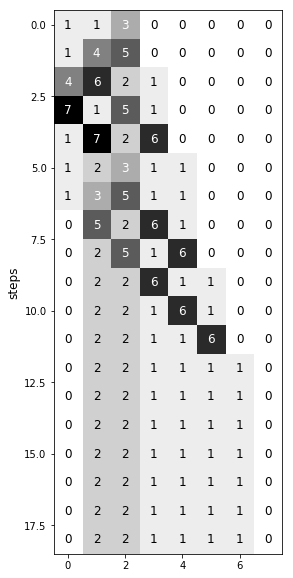

In [58]:
res = testRulesOneDimension([1,1,3,0,0,0,0,0],18,oRules)
plotCA(res["history"])

In [60]:
literals = {}
literalsInv = {}
count = 0
for key in oRules:
    sel = oRules[key].replace("(","").replace(")","").replace("or",",").replace("and",",").replace(" ","").split(",")
    for el in sel:
        if el not in literals:
            literals[el] = "X{}".format(count)
            literalsInv["X{}".format(count)] = el
            count += 1
literals    

{'A0<4': 'X0',
 'A0<2': 'X1',
 'A0>=3': 'X2',
 'A1<1': 'X3',
 'A0<1': 'X4',
 'A0>=1': 'X5',
 'A1<2': 'X6',
 'A2<4': 'X7',
 'A2>=3': 'X8',
 'A0<5': 'X9',
 'A0>=6': 'X10',
 'A1>=4': 'X11',
 'A1>=6': 'X12',
 'A0<3': 'X13',
 'A0>=4': 'X14',
 'A1<7': 'X15',
 'A1>=1': 'X16',
 'A0>=2': 'X17',
 'A2<3': 'X18',
 'A2>=4': 'X19',
 'A2<2': 'X20',
 'A2>=5': 'X21',
 'A1<3': 'X22',
 'A1>=3': 'X23',
 'A1>=5': 'X24',
 'A1>=2': 'X25',
 'A1<6': 'X26',
 'A1>=7': 'X27',
 'A0>=7': 'X28',
 'A2>=2': 'X29',
 'A2<5': 'X30',
 'A0<7': 'X31',
 'A1<4': 'X32',
 'A0>=5': 'X33',
 'A0<6': 'X34',
 'A1<5': 'X35',
 'A2>=6': 'X36'}

In [61]:
clausulesWLiterals = {}
for key in oRules:
    clsstr = oRules[key].replace(" ","").replace("or"," or ").replace("and"," and ")
    count = 0
    for key3 in literals:
        if key3 in clsstr:
            clsstr = clsstr.replace(key3,literals[key3])
            count += 1
    if key not in clausulesWLiterals:
        clausulesWLiterals[key] = {}
    clausulesWLiterals[key]=[clsstr,count]
clausulesWLiterals

{0: ['(X0) and (X1 or X2) and (X3 or X4) and (X5 or X6) and (X5 or X3 or X7) and (X5 or X3 or X8)',
  9],
 1: ['(X9 or X10 or X3) and (X1 or X2 or X6 or X11) and (X9 or X3) and (X6 or X11) and (X1 or X2 or X6 or X12) and (X13 or X14 or X6) and (X6 or X12) and (X15 or X4) and (X16 or X17) and (X13 or X14 or X16) and (X5 or X18 or X19) and (X20 or X19 or X17 or X4) and (X5 or X18 or X21)',
  19],
 2: ['(X9) and (X22 or X11) and (X17 or X4 or X23) and (X17 or X4 or X24) and (X5 or X16) and (X13 or X16) and (X5 or X25) and (X5 or X22 or X24) and (X17 or X26 or X27) and (X25) and (X26 or X1) and (X5 or X26)',
  14],
 3: ['(X10 or X1) and (X28 or X1) and (X17 or X22) and (X5) and (X17 or X16) and (X25)',
  8],
 4: ['(X1) and (X6) and (X16) and (X5 or X19) and (X29) and (X7 or X4) and (X5 or X30)',
  9],
 5: ['(X31) and (X17 or X23) and (X2 or X23) and (X2 or X32) and (X14 or X13) and (X33 or X13) and (X34 or X25) and (X25)',
  10],
 6: ['(X10 or X1 or X6) and (X6 or X1) and (X17 or X11) and 

In [62]:
simpExpr = {}
for key in clausulesWLiterals:
    strexpr = clausulesWLiterals[key][0]
    print(key)
    strexpr = strexpr.replace("or","|").replace("and","&").replace("[","").replace("]","")
    strsimp = str(simplify_logic(strexpr,force=(clausulesWLiterals[key][1] >= 8)))
    strsimp = strsimp.replace("|","or").replace("&","and")
    if key not in simpExpr:
        simpExpr[key] = ""
    simpExpr[key] = strsimp
simpExpr

0
1


KeyboardInterrupt: 

In [ ]:
simpExpr2 = {}
for key in simpExpr:
    for key2 in simpExpr[key]:
        temp = simpExpr[key][key2].replace(")"," )") + " "
        for key3 in literalsInv:
            temp = temp.replace(key3+" ",literalsInv[key3]+" ")
        if key not in simpExpr2:
            simpExpr2[key] = {}
        if key2 not in simpExpr2[key]:
            simpExpr2[key][key2] = ""
        simpExpr2[key][key2] = temp
simpExpr2

In [ ]:
res = testRulesOneDimension2([1,1,3,0,0,0,0,0],18,simpExpr2)
plotCA(res["history"])